In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    #google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    !pip install einops
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        !pip install einops
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Cloning into 'dl_basics'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 422 (delta 66), reused 70 (delta 31), pack-reused 285
Receiving objects: 100% (422/422), 24.18 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 309.2 kB/s eta 0:00:00
Found GPU: Tesla T4.


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from einops import rearrange

In [3]:
def plot_matrix(m, ax, scale=1.0, transpose=False):
    m = np.copy(m)
    mmax = np.max(np.abs(m)) / scale
    if transpose:
        m = m.T
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

Use the elephant image to understand the image preprocessing step. From Keras docs: vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling

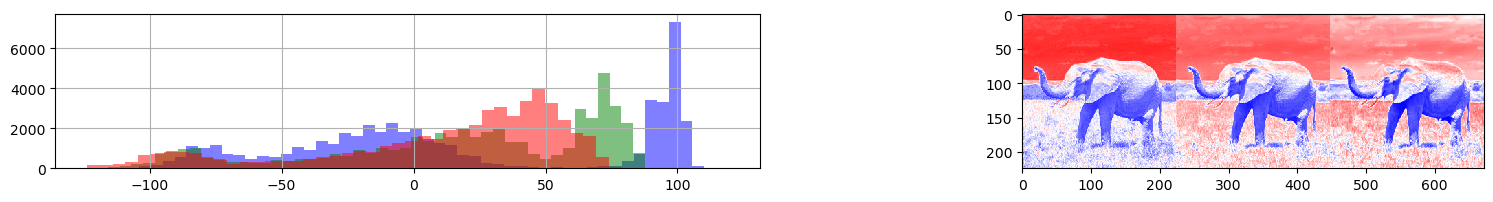

In [ ]:
img_path = '../input/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

fig, axs = plt.subplots(1,2, figsize=(20,2))
axs[0].grid(True)
axs[0].hist(x.reshape(-1,3)[:,0], bins=50, color="blue", alpha=0.5);
axs[0].hist(x.reshape(-1,3)[:,1], bins=50, color="green", alpha=0.5);
axs[0].hist(x.reshape(-1,3)[:,2], bins=50, color="red", alpha=0.5);
plot_matrix(rearrange(x[0,:,:,:], "h w c -> h (c w)"), axs[1])

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    print(layer.name, [ w.shape for w in layer.get_weights() ])

58889256/58889256 [==============================] - 3s 0us/step
input_1 []
block1_conv1 [(3, 3, 3, 64), (64,)]
block1_conv2 [(3, 3, 64, 64), (64,)]
block1_pool []
block2_conv1 [(3, 3, 64, 128), (128,)]
block2_conv2 [(3, 3, 128, 128), (128,)]
block2_pool []
block3_conv1 [(3, 3, 128, 256), (256,)]
block3_conv2 [(3, 3, 256, 256), (256,)]
block3_conv3 [(3, 3, 256, 256), (256,)]
block3_pool []
block4_conv1 [(3, 3, 256, 512), (512,)]
block4_conv2 [(3, 3, 512, 512), (512,)]
block4_conv3 [(3, 3, 512, 512), (512,)]
block4_pool []
block5_conv1 [(3, 3, 512, 512), (512,)]
block5_conv2 [(3, 3, 512, 512), (512,)]
block5_conv3 [(3, 3, 512, 512), (512,)]
block5_pool []


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

layer_name = "block1_conv1"
base_model.get_layer(layer_name).activation = None
model_feat = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
model_feat.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 112ms/step
(224, 224, 64)


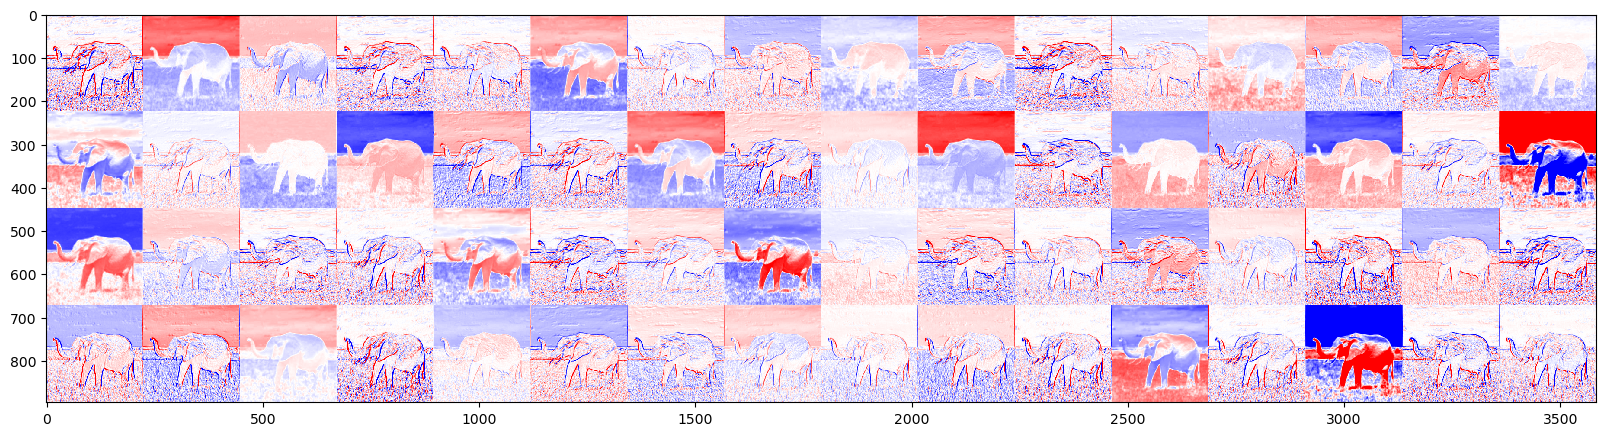

In [ ]:
layer_output = model_feat.predict(x).squeeze()
print(layer_output.shape)

fig, ax = plt.subplots(1, 1, figsize=(20,10))
m = rearrange(layer_output, "h w (c1 c2) -> (c1 h) (c2 w)", c2=16)
plot_matrix(m, ax, scale=4)

In [110]:
def build_neuron_opt_model(feat_model, filter):

    inp = tf.keras.Input(shape=(1,), name="input_const1")
    
    x = tf.keras.layers.Dense(
        units = 224 * 224 * 3,
        kernel_regularizer = tf.keras.regularizers.L2(1e-3),
        use_bias = False,
        name = "image_layer"
    )(inp)

    x_img = tf.keras.layers.Reshape((224,224,3), name="image_reshape")(x)

    x = feat_model(x_img)

    out = tf.math.reduce_mean(x[:, :, :, filter], axis=(1,2)) # avoid border artifacts
    
    feat_model.trainable = False
    
    model_generate = tf.keras.Model(inp, x_img, name="model_generate")
    model_train    = tf.keras.Model(inp, out,   name="model_train")

    model_train.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        #optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e+1, weight_decay=0),
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-0),
    )
    
    return model_generate, model_train

In [111]:
model_generate, model_train = build_neuron_opt_model(model_feat, 1)

In [112]:
model_train.summary()

Model: "model_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_const1 (InputLayer)   [(None, 1)]               0         
                                                                 
 image_layer (Dense)         (None, 150528)            150528    
                                                                 
 image_reshape (Reshape)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 224, 224, 64)      1792      
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.math.reduce_mean_11 (TFO  (None,)                  0         
 pLambda)                                              

1/1 [==============================] - 0s 54ms/step


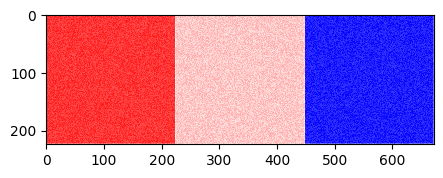

In [118]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
plot_matrix(rearrange(model_generate.predict([1])[0,:,:,:], "h w c -> h (c w)"), ax, scale=1)

In [114]:
model_train.evaluate([1], [1])

1/1 [==============================] - 0s 196ms/step - loss: 0.6495


0.6495363712310791

In [115]:
model_train.fit([1], [1], batch_size=1, epochs=1024*1, callbacks=[TqdmCallback(verbose=0)], verbose=0)

0epoch [00:00, ?epoch/s]

In [116]:
model_train.predict([1])

1/1 [==============================] - 0s 83ms/step


array([0.11108374], dtype=float32)

1/1 [==============================] - 0s 34ms/step


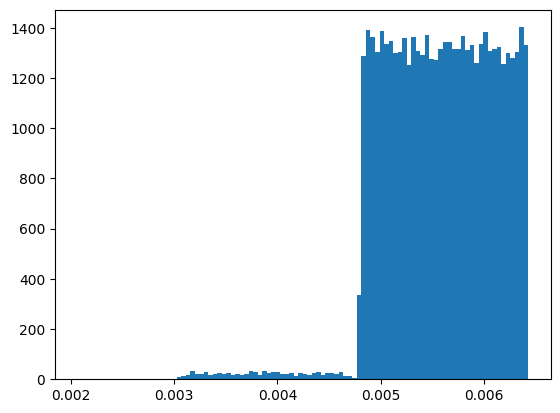

In [117]:
plt.hist(model_generate.predict([1])[0,:,:,0].reshape(-1), bins=100);

In [44]:
model_generate.predict([1])[0,2:-2,2:-2,0]

1/1 [==============================] - 0s 30ms/step


array([[ 0.9709009 ,  0.9599625 ,  0.9599625 , ...,  0.95996267,
         0.9599626 , -0.43683097],
       [ 0.9638276 ,  0.4589635 ,  0.45896345, ...,  0.45896378,
         0.4589635 , -0.95732623],
       [ 0.96382767,  0.45896375,  0.45896357, ...,  0.45896378,
         0.45896375, -0.95732623],
       ...,
       [ 0.9638277 ,  0.45896363,  0.45896384, ...,  0.45896375,
         0.45896366, -0.9573263 ],
       [ 0.96382767,  0.45896357,  0.45896375, ...,  0.4589639 ,
         0.45896384, -0.9573263 ],
       [-0.22926219, -0.96135837, -0.9613585 , ..., -0.96135837,
        -0.9613586 , -0.96760046]], dtype=float32)